#### Multiple linear regression for "Rating", using `[['owned', 'yearpublished', 'maxplayers', 'minage']]`
#### Followed by controling for `[['owned', 'yearpublished']]`, and mantaining `[['maxplayers', 'minage']]` as IVs.

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

import scipy.stats as stats

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm #needed for Cooks distance


# Load the data
ratings_data = pd.read_csv('./ratings.csv')
details_data = pd.read_csv('./details.csv')

# Rename columns in the ratings data for clarity
ratings_data_renamed = ratings_data.rename(columns={
    'rank': 'rating_rank',
    'average': 'rating_average',
    'bayes_average': 'rating_bayes_average',
    'users_rated': 'rating_users_rated'
})

# Merge the datasets on 'id' and 'num'
combined_data = pd.merge(ratings_data_renamed, details_data, on=['id'], suffixes=('_rating', '_details'))

# Drop unnecessary columns
columns_to_drop = ['url', 'thumbnail', 'description', 'boardgamepublisher', 'boardgamedesigner', 'boardgameartist']
cleaned_data = combined_data.drop(columns=columns_to_drop)

# Convert categorical data to numeric format using one-hot encoding
# cleaned_data = pd.get_dummies(cleaned_data, columns=['boardgamecategory', 'boardgamemechanic', 'boardgamefamily', 'boardgameexpansion', 'boardgameimplementation'])
# cleaned_data = cleaned_data.drop(['boardgamecategory', 'boardgamemechanic', 'boardgamefamily', 'boardgameexpansion', 'boardgameimplementation'], axis=1)

# Check for duplicates and drop them
cleaned_data = cleaned_data.drop_duplicates()


cat = cleaned_data.select_dtypes(include=['object'])
#drop categorical because encoding and scaling is troublesome for regression. 
cleaned_data_num = cleaned_data.drop(columns=cat.columns)

# Prepare data for modeling
X = cleaned_data_num[['owned', 'yearpublished', 'minplayers', 'minage']]
y = cleaned_data_num['rating_average']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [2]:
cleaned_data_num.describe()

,num_rating,id,year,rating_rank,rating_average,rating_bayes_average,rating_users_rated,num_details,yearpublished,minplayers,maxplayers,playingtime,minplaytime,maxplaytime,minage,owned,trading,wanting,wishing
count,21631.000000,21631.000000,21631.000000,21631.000000,21631.000000,21631.000000,21631.000000,21631.000000,21631.000000,21631.000000,21631.000000,21631.000000,21631.000000,21631.000000,21631.000000,21631.000000,21631.000000,21631.000000,21631.000000
mean,10878.522352,118133.093847,1988.101290,10879.522352,6.417249,5.683664,874.548518,10815.000000,1986.094910,2.007027,5.709491,90.509177,63.647774,90.509177,9.611391,1487.924553,43.585965,42.030373,233.655587
std,6311.917913,105310.419253,190.115056,6311.917913,0.929345,0.366096,3695.946026,6244.476172,210.042496,0.688957,15.102385,534.826511,447.213702,534.826511,3.640562,5395.077773,102.410851,117.940355,800.657809
min,0.000000,1.000000,0.000000,1.000000,1.040000,0.000000,30.000000,0.000000,-3500.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,5407.500000,12280.500000,2001.000000,5408.500000,5.830000,5.510000,57.000000,5407.500000,2001.000000,2.000000,4.000000,25.000000,20.000000,25.000000,8.000000,150.000000,5.000000,3.000000,14.000000
50%,10838.000000,105187.000000,2011.000000,10839.000000,6.450000,5.546000,124.000000,10815.000000,2011.000000,2.000000,4.000000,45.000000,30.000000,45.000000,10.000000,322.000000,13.000000,9.000000,39.000000
75%,16355.500000,207013.000000,2017.000000,16356.500000,7.040000,5.678000,397.000000,16222.500000,2017.000000,2.000000,6.000000,90.000000,60.000000,90.000000,12.000000,903.500000,38.000000,29.000000,131.000000
max,21830.000000,350992.000000,3500.000000,21831.000000,9.570000,8.511000,108975.000000,21630.000000,2023.000000,10.000000,999.000000,60000.000000,60000.000000,60000.000000,25.000000,168364.000000,2508.000000,2011.000000,19325.000000


In [3]:
# Train a linear regression model
model = LinearRegression()
model.fit(X_train, y_train)


LinearRegression()

In [4]:
# Make predictions
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)


In [5]:
# Evaluate the model
r2_train = r2_score(y_train, y_pred_train)
r2_test = r2_score(y_test, y_pred_test)
mae_train = mean_absolute_error(y_train, y_pred_train)
mae_test = mean_absolute_error(y_test, y_pred_test)
mse_train = mean_squared_error(y_train, y_pred_train)
mse_test = mean_squared_error(y_test, y_pred_test)

print(f"R² score on training data: {r2_train}")
print(f"R² score on test data: {r2_test}")
print(f"Mean Absolute Error on training data: {mae_train}")
print(f"Mean Absolute Error on test data: {mae_test}")
print(f"Mean Squared Error on training data: {mse_train}")
print(f"Mean Squared Error on test data: {mse_test}")


R² score on training data: 0.10266755878038103
R² score on test data: 0.08177392274376438
Mean Absolute Error on training data: 0.6753542921891051
Mean Absolute Error on test data: 0.6933249441906189
Mean Squared Error on training data: 0.7726486139636355
Mean Squared Error on test data: 0.8014481294370828


In [6]:
# Print model coefficients
coefficients = pd.DataFrame(model.coef_, X.columns, columns=['Coefficient'])
print("\nModel Coefficients:")
print(coefficients)


Model Coefficients:
               Coefficient
owned             0.148075
yearpublished     0.052153
minplayers       -0.172388
minage            0.171143


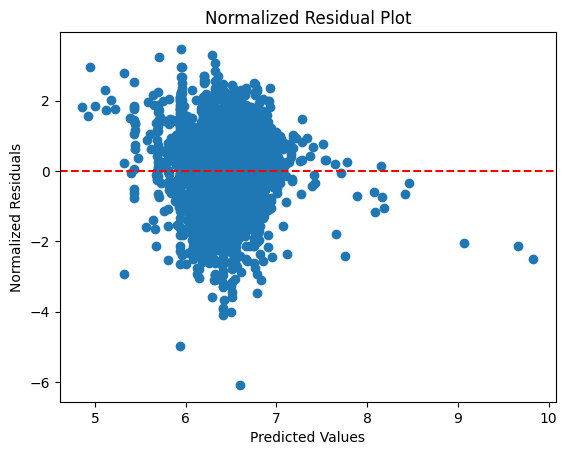

In [7]:

# Calculate the residuals
residuals = y_test - y_pred_test

# Normalize the residuals
normalized_residuals = residuals / np.std(residuals)

# Plot the normalized residuals against the predicted values
plt.scatter(y_pred_test, normalized_residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Normalized Residuals')
plt.title('Normalized Residual Plot')
plt.show()

In [9]:
# Using statsmodels
X_ols = sm.add_constant(X)
model = sm.OLS(y, X_ols).fit()
predictions_statsmodels = model.predict(X_ols)
summary = model.summary()
print(summary)

                            OLS Regression Results                            
Dep. Variable:         rating_average   R-squared:                       0.099
Model:                            OLS   Adj. R-squared:                  0.099
Method:                 Least Squares   F-statistic:                     592.7
Date:                Sat, 08 Jun 2024   Prob (F-statistic):               0.00
Time:                        08:19:10   Log-Likelihood:                -27982.
No. Observations:               21631   AIC:                         5.597e+04
Df Residuals:                   21626   BIC:                         5.601e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             5.9051      0.061     97.391

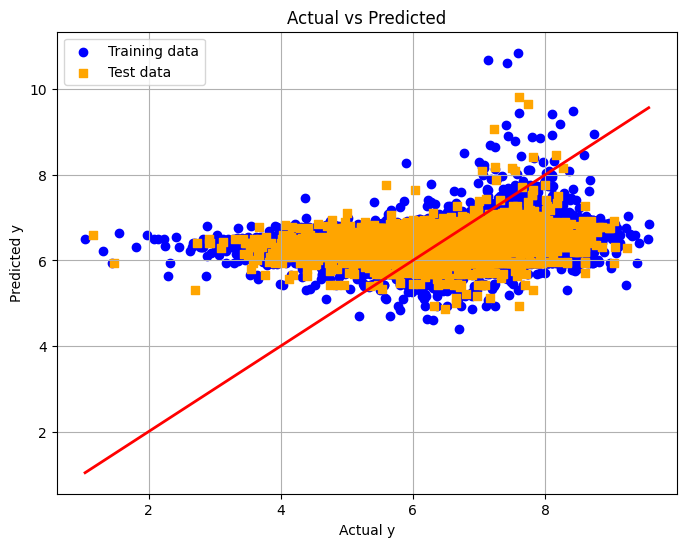

In [10]:

# Plot predicted vs actual y
plt.figure(figsize=(8, 6))
plt.scatter(y_train, y_pred_train, c='blue', marker='o', label='Training data')
plt.scatter(y_test, y_pred_test, c='orange', marker='s', label='Test data')
plt.xlabel('Actual y')
plt.ylabel('Predicted y')
plt.plot([min(y_train.min(), y_test.min()), max(y_train.max(), y_test.max())], [min(y_train.min(), y_test.min()), max(y_train.max(), y_test.max())], color='red', lw=2)
plt.legend(loc='upper left')
plt.title('Actual vs Predicted')
plt.grid(True)
plt.show()

In [11]:
cleaned_data_num

,num_rating,id,year,rating_rank,rating_average,rating_bayes_average,rating_users_rated,num_details,yearpublished,minplayers,maxplayers,playingtime,minplaytime,maxplaytime,minage,owned,trading,wanting,wishing
0,105,30549,2008,106,7.59,7.487,108975,0,2008,2,4,45,45,45,8,168364,2508,625,9344
1,189,822,2000,190,7.42,7.309,108738,1,2000,2,5,45,30,45,7,161299,1716,582,7383
2,428,13,1995,429,7.14,6.970,108024,2,1995,3,4,120,60,120,10,167733,2018,485,5890
3,72,68448,2010,73,7.74,7.634,89982,3,2010,2,7,30,30,30,10,120466,1567,1010,12105
4,103,36218,2008,104,7.61,7.499,81561,4,2008,2,4,30,30,30,13,106956,2009,655,8621
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21626,12748,296892,2020,12749,7.37,5.531,30,21626,2020,3,9,30,20,30,8,112,8,4,32
21627,15016,217378,2016,15017,6.61,5.517,30,21627,2016,1,5,30,15,30,10,64,1,6,21
21628,19459,18063,1970,19460,5.00,5.488,30,21628,1970,2,4,60,60,60,10,98,7,4,5
21629,17256,10052,1989,17257,5.80,5.505,30,21629,1989,2,4,10,10,10,5,52,4,8,13


### Filter on recent games after 1945. Reasons for it in EDA. 

### this moves model performance of 4 predictor from R^2 of 0.18 to 0.28

In [12]:
#we will focus our analysis on games published after 1945. 
cleaned_data_num = cleaned_data_num[cleaned_data_num['yearpublished'] >= 1945]

### filter on games with more than ``250 ratings``

### A lot of data is lost this way, focusing our attention on 1/3rd of the data... But what we lose is noisy data with a lot of variability, which would make our model too broad and unhelpful. If you can make it to 250 ratings, this model's predictions can help.

### There are risks involved, but this can allow us to see what the moderately to highly popular games have in common. There are many reasons a game doesnt climb the ranks, and there are a few that we want to learn of what helps the ones that do climb the leader `board` :)


In [47]:

#filter on games with more than 250 ratings
popular_cleaned_data_num = cleaned_data_num[cleaned_data_num['rating_users_rated'] > 250]

popular_cleaned_data_num.describe()

,num_rating,id,year,rating_rank,rating_average,rating_bayes_average,rating_users_rated,num_details,yearpublished,minplayers,maxplayers,playingtime,minplaytime,maxplaytime,minage,owned,trading,wanting,wishing
count,7088.000000,7088.000000,7088.000000,7088.000000,7088.000000,7088.000000,7088.000000,7088.000000,7088.000000,7088.000000,7088.000000,7088.000000,7088.000000,7088.000000,7088.000000,7088.000000,7088.000000,7088.000000,7088.000000
mean,4996.035835,121086.404204,2008.668172,4997.035835,6.721941,5.992114,2442.901524,3599.021163,2008.668172,1.982647,5.710356,87.620344,59.549661,87.620344,10.474323,3986.220796,109.472489,108.863008,624.647291
std,5107.095175,101310.758878,11.688296,5107.095175,0.751826,0.500807,6127.780948,2076.181708,11.688296,0.684739,14.579068,372.420273,130.280691,372.420273,2.861048,8863.260935,158.057471,187.822554,1308.384827
min,0.000000,1.000000,1946.000000,1.000000,1.160000,3.801000,251.000000,0.000000,1946.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,13.000000,0.000000,0.000000,2.000000
25%,1786.750000,15578.000000,2004.000000,1787.750000,6.260000,5.654000,398.000000,1799.750000,2004.000000,2.000000,4.000000,30.000000,25.000000,30.000000,8.000000,883.000000,31.000000,18.000000,89.000000
50%,3577.500000,125037.000000,2012.000000,3578.500000,6.730000,5.832000,721.500000,3602.500000,2012.000000,2.000000,4.000000,45.000000,45.000000,45.000000,10.000000,1545.000000,62.000000,44.000000,212.000000
75%,5830.250000,205331.250000,2017.000000,5831.250000,7.230000,6.198000,1820.000000,5394.250000,2017.000000,2.000000,6.000000,90.000000,60.000000,90.000000,12.000000,3399.250000,125.000000,112.000000,565.500000
max,21827.000000,350736.000000,2022.000000,21828.000000,8.970000,8.511000,108975.000000,7199.000000,2022.000000,8.000000,999.000000,22500.000000,5400.000000,22500.000000,21.000000,168364.000000,2508.000000,2011.000000,19325.000000


In [48]:


# Prepare data for modeling
X = popular_cleaned_data_num[['owned', 'yearpublished', 'minplayers', 'minage']]
y = popular_cleaned_data_num['rating_average']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Train a linear regression model
model = LinearRegression()
model.fit(X_train, y_train)


# Make predictions
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

# Evaluate the model
r2_train = r2_score(y_train, y_pred_train)
r2_test = r2_score(y_test, y_pred_test)
mae_train = mean_absolute_error(y_train, y_pred_train)
mae_test = mean_absolute_error(y_test, y_pred_test)
mse_train = mean_squared_error(y_train, y_pred_train)
mse_test = mean_squared_error(y_test, y_pred_test)
residuals = y_train - y_pred_train
_, p_value = stats.ttest_1samp(residuals, 0)

print("p-value:", p_value)
print(f"R² score on training data: {r2_train}")
print(f"R² score on test data: {r2_test}")
print(f"Mean Absolute Error on training data: {mae_train}")
print(f"Mean Absolute Error on test data: {mae_test}")
print(f"Mean Squared Error on training data: {mse_train}")
print(f"Mean Squared Error on test data: {mse_test}")

# Print model coefficients
coefficients = pd.DataFrame(model.coef_, X.columns, columns=['Coefficient'])
print("\nModel Coefficients:")
print(coefficients)





p-value: 0.9999999999999283
R² score on training data: 0.28412216270964485
R² score on test data: 0.31988702166527194
Mean Absolute Error on training data: 0.4782538672122105
Mean Absolute Error on test data: 0.4962433935358754
Mean Squared Error on training data: 0.3980613852935722
Mean Squared Error on test data: 0.4091675136513879

Model Coefficients:
               Coefficient
owned             0.152179
yearpublished     0.255953
minplayers       -0.122207
minage            0.163551


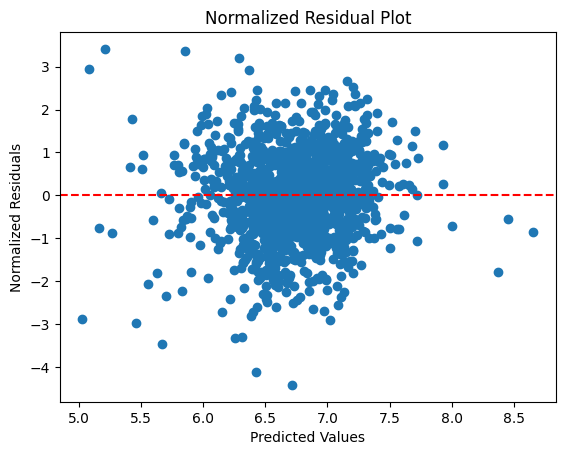

In [49]:

# Calculate the residuals
residuals = y_test - y_pred_test

# Normalize the residuals
normalized_residuals = residuals / np.std(residuals)

# Plot the normalized residuals against the predicted values
plt.scatter(y_pred_test, normalized_residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Normalized Residuals')
plt.title('Normalized Residual Plot')
plt.show()

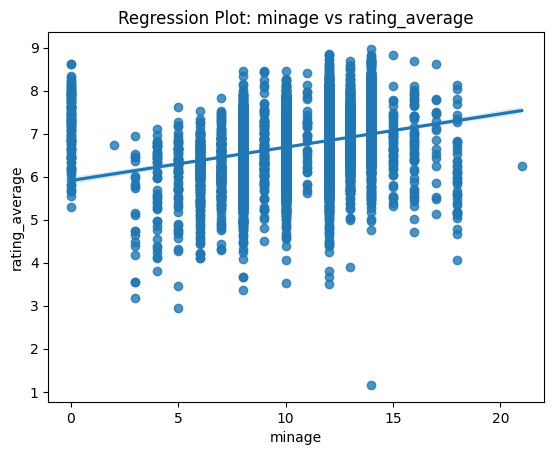

In [50]:
import seaborn as sns

import matplotlib.pyplot as plt

# Create a scatter plot with regression line
sns.regplot(x='minage', y='rating_average', data=popular_cleaned_data_num)

# Set plot title and labels
plt.title('Regression Plot: minage vs rating_average')
plt.xlabel('minage')
plt.ylabel('rating_average')

# Show the plot
plt.show()

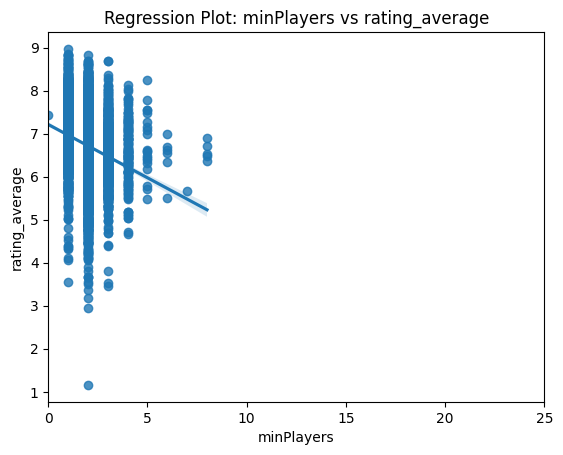

In [51]:
import seaborn as sns

import matplotlib.pyplot as plt

# Create a scatter plot with regression line
sns.regplot(x='minplayers', y='rating_average', data=popular_cleaned_data_num)

# Set plot title and labels
plt.title('Regression Plot: minPlayers vs rating_average')
plt.xlabel('minPlayers')
plt.ylabel('rating_average')
plt.xlim(0, 25)

# Show the plot
plt.show()



C:\Users\mariu\AppData\Local\Temp\ipykernel_2600\2086485393.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  popular_cleaned_data_num['owned_log10'] = np.log10(popular_cleaned_data_num['owned'])


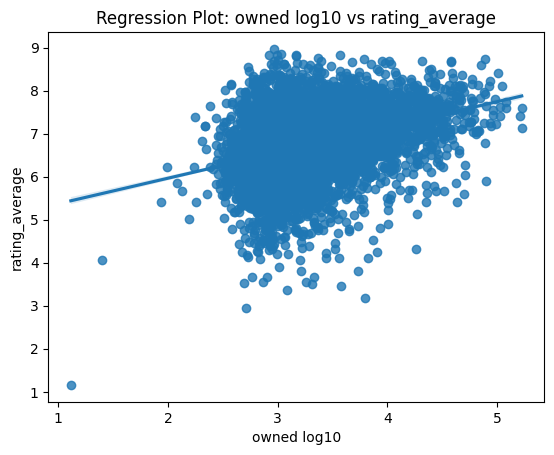

In [52]:
import seaborn as sns

import matplotlib.pyplot as plt

popular_cleaned_data_num['owned_log10'] = np.log10(popular_cleaned_data_num['owned'])


# Create a scatter plot with regression line
sns.regplot(x='owned_log10', y='rating_average', data=popular_cleaned_data_num)

# Set plot title and labels
plt.title('Regression Plot: owned log10 vs rating_average')
plt.xlabel('owned log10')
plt.ylabel('rating_average')

# Show the plot
plt.show()




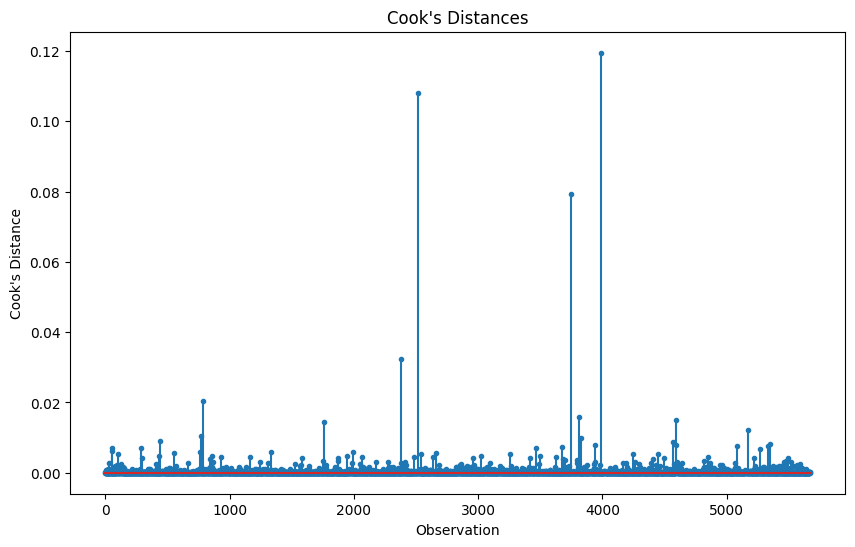

In [53]:

# Train a linear regression model using statsmodels
model_sm = sm.OLS(y_train, sm.add_constant(X_train))
model_sm_fit = model_sm.fit()

# Calculate Cook's distance values
influence = model_sm_fit.get_influence()
cooks_distance = influence.cooks_distance[0]

cooks_distance = cooks_distance.reshape(-1, 1)
cooks_distance_ids = np.concatenate((np.arange(len(cooks_distance)).reshape(-1, 1), cooks_distance), axis=1)
cooks_distance_ids = cooks_distance_ids[cooks_distance_ids[:, 1] > 1]
for row in cooks_distance_ids:
    print(f"ID: {int(row[0])}, Cook's Distance: {row[1]}")

# Plot Cook's distance values
import matplotlib.pyplot as plt

# Plot Cook's distances
plt.figure(figsize=(10, 6))
plt.stem(cooks_distance, markerfmt=".")
plt.xlabel("Observation")
plt.ylabel("Cook's Distance")
plt.title("Cook's Distances")
plt.show()





## We conclude that there are no problems with Anomalous data 
### (only 2 out of N=7200 (popularity filtered) entries have Cooks distance > 1)

### TODO: Control for ``Year``, not in our control

In [54]:
popular_cleaned_data_num['yearpublished'].describe()

count    7088.000000
mean     2008.668172
std        11.688296
min      1946.000000
25%      2004.000000
50%      2012.000000
75%      2017.000000
max      2022.000000
Name: yearpublished, dtype: float64

In [55]:
# Prepare data for modeling
X = popular_cleaned_data_num[['owned', 'minplayers', 'minage']]
y = popular_cleaned_data_num['rating_average']

# Add 'yearpublished' as a covariate
covariate = popular_cleaned_data_num['yearpublished']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
covariate_train, covariate_test = train_test_split(covariate, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Train a linear regression model with 'yearpublished' as a covariate
model = LinearRegression()
model.fit(X_train, y_train, sample_weight=covariate_train)

# Make predictions
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

# Evaluate the model
r2_train = r2_score(y_train, y_pred_train)
r2_test = r2_score(y_test, y_pred_test)
mae_train = mean_absolute_error(y_train, y_pred_train)
mae_test = mean_absolute_error(y_test, y_pred_test)
mse_train = mean_squared_error(y_train, y_pred_train)
mse_test = mean_squared_error(y_test, y_pred_test)
residuals = y_train - y_pred_train
_, p_value = stats.ttest_1samp(residuals, 0)

print("p-value:", p_value)
print(f"R² score on training data: {r2_train}")
print(f"R² score on test data: {r2_test}")
print(f"Mean Absolute Error on training data: {mae_train}")
print(f"Mean Absolute Error on test data: {mae_test}")
print(f"Mean Squared Error on training data: {mse_train}")
print(f"Mean Squared Error on test data: {mse_test}")

# Print model coefficients
coefficients = pd.DataFrame(model.coef_, X.columns, columns=['Coefficient'])
print("\nModel Coefficients:")
print(coefficients)


p-value: 0.8730387884218076
R² score on training data: 0.17020935482729582
R² score on test data: 0.19796210398904657
Mean Absolute Error on training data: 0.5147334813870068
Mean Absolute Error on test data: 0.5333906554069419
Mean Squared Error on training data: 0.4614022065151923
Mean Squared Error on test data: 0.48251961397431153

Model Coefficients:
            Coefficient
owned          0.156223
minplayers    -0.154352
minage         0.194540


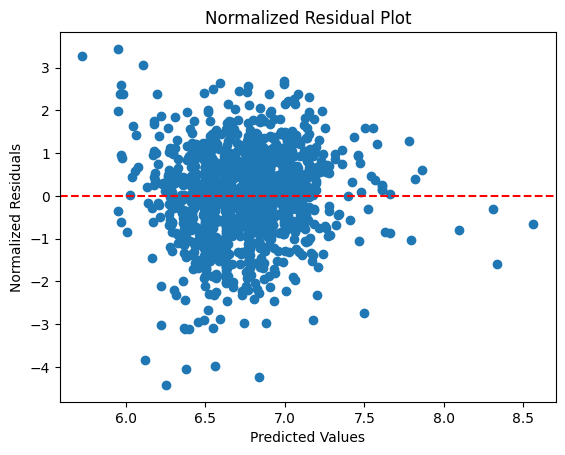

In [56]:

# Calculate the residuals
residuals = y_test - y_pred_test

# Normalize the residuals
normalized_residuals = residuals / np.std(residuals)

# Plot the normalized residuals against the predicted values
plt.scatter(y_pred_test, normalized_residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Normalized Residuals')
plt.title('Normalized Residual Plot')
plt.show()

In [96]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from tabulate import tabulate

# Prepare data for modeling
X_full = popular_cleaned_data_num[['owned', 'minplayers', 'minage', 'yearpublished']]
X_reduced = popular_cleaned_data_num[['minplayers', 'minage']]
y = popular_cleaned_data_num['rating_average']

# Split the data
X_train_full, X_test_full, y_train, y_test = train_test_split(X_full, y, test_size=0.2, random_state=42)
X_train_reduced, X_test_reduced, _, _ = train_test_split(X_reduced, y, test_size=0.2, random_state=42)

# Standardize the data
scaler_full = StandardScaler()
X_train_full_scaled = scaler_full.fit_transform(X_train_full)
X_test_full_scaled = scaler_full.transform(X_test_full)

scaler_reduced = StandardScaler()
X_train_reduced_scaled = scaler_reduced.fit_transform(X_train_reduced)
X_test_reduced_scaled = scaler_reduced.transform(X_test_reduced)

# Add a constant term for the intercept in statsmodels
X_train_full_scaled = sm.add_constant(X_train_full_scaled)
X_test_full_scaled = sm.add_constant(X_test_full_scaled)
X_train_reduced_scaled = sm.add_constant(X_train_reduced_scaled)
X_test_reduced_scaled = sm.add_constant(X_test_reduced_scaled)

# Fit the models using statsmodels
model_full = sm.OLS(y_train, X_train_full_scaled).fit()
model_reduced = sm.OLS(y_train, X_train_reduced_scaled).fit()

# Get the model summaries
summary_full = model_full.summary()
summary_reduced = model_reduced.summary()
print("Full Model Summary:")
print(summary_full)
print("\nModel excluding Owned, YearPublished - Summary:")
print(summary_reduced)

# Predict on the test data
y_pred_test_full = model_full.predict(X_test_full_scaled)
y_pred_test_reduced = model_reduced.predict(X_test_reduced_scaled)



# Get the summary table
summary_full = model_full.summary()

# Extract the desired statistics
dep_variable = summary_full.tables[0].data[0][1]
r_squared = float(summary_full.tables[0].data[0][3])
adj_r_squared = float(summary_full.tables[0].data[1][3])
f_statistic = float(summary_full.tables[0].data[2][3])
df_residuals = (summary_full.tables[0].data[6][1])
df_model_only = (summary_full.tables[0].data[7][1])

# Create a new table to display the statistics
table_data = [
    ['Dep. Variable:', dep_variable],
    ['R-squared:', r_squared],
    ['Adj. R-squared:', adj_r_squared],
    ['F-statistic:', f_statistic],
    ['DF Residuals:', df_residuals],
    ['DF Model only:', df_model_only]
]

table_headers = ['Statistic', 'Value']

# Display the table
print(tabulate(table_data, headers=table_headers))


# Get the summary table
summary_reduced = model_reduced.summary()

# Extract the desired statistics
dep_variable = summary_reduced.tables[0].data[0][1]
r_squared = float(summary_reduced.tables[0].data[0][3])
adj_r_squared = float(summary_reduced.tables[0].data[1][3])
f_statistic = float(summary_reduced.tables[0].data[2][3])
df_residuals = (summary_reduced.tables[0].data[6][1])
df_model_only = (summary_reduced.tables[0].data[7][1])

# Create a new table to display the statistics
table_data = [
    ['Dep. Variable:', dep_variable],
    ['R-squared:', r_squared],
    ['Adj. R-squared:', adj_r_squared],
    ['F-statistic:', f_statistic],
    ['DF Residuals:', df_residuals],
    ['DF Model only:', df_model_only]
]

table_headers = ['Statistic', 'Value']

# Display the table
print(tabulate(table_data, headers=table_headers))


# OLS Full Model Summary
ols_full_summary = model_full.summary()
ols_full_table = ols_full_summary.tables[1]
ols_full_headers = ols_full_table.pop(0)
ols_full_table_markdown = tabulate(ols_full_table, headers=ols_full_headers, tablefmt="pipe")

# OLS Reduced Model Summary
ols_reduced_summary = model_reduced.summary()
ols_reduced_table = ols_reduced_summary.tables[1]
ols_reduced_headers = ols_reduced_table.pop(0)
ols_reduced_table_markdown = tabulate(ols_reduced_table, headers=ols_reduced_headers, tablefmt="pipe")

print("OLS Full Model Summary:")
print(ols_full_table_markdown)
print("\nOLS Reduced Model Summary:")
print(ols_reduced_table_markdown)

Full Model Summary:
                            OLS Regression Results                            
Dep. Variable:         rating_average   R-squared:                       0.284
Model:                            OLS   Adj. R-squared:                  0.284
Method:                 Least Squares   F-statistic:                     562.1
Date:                Sat, 08 Jun 2024   Prob (F-statistic):               0.00
Time:                        10:22:20   Log-Likelihood:                -5433.9
No. Observations:                5670   AIC:                         1.088e+04
Df Residuals:                    5665   BIC:                         1.091e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          6.7220      0.008

### TODO:  Control for ``Owned``, initially not in our control. In short: there is a reason the game is in demand and popular: something made it so. We want to see if there are other factors in play, so we will see what happens when we control for it.

In [97]:
# Prepare data for modeling
X = popular_cleaned_data_num[[ 'minplayers', 'minage']]
y = popular_cleaned_data_num['rating_average']

# Add 'yearpublished' as a covariate
covariate = popular_cleaned_data_num['owned']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
covariate_train, covariate_test = train_test_split(covariate, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Train a linear regression model with 'yearpublished' as a covariate
model = LinearRegression()
model.fit(X_train, y_train, sample_weight=covariate_train)

# Make predictions
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

# Evaluate the model
r2_train = r2_score(y_train, y_pred_train)
r2_test = r2_score(y_test, y_pred_test)
mae_train = mean_absolute_error(y_train, y_pred_train)
mae_test = mean_absolute_error(y_test, y_pred_test)
mse_train = mean_squared_error(y_train, y_pred_train)
mse_test = mean_squared_error(y_test, y_pred_test)
residuals = y_train - y_pred_train
_, p_value = stats.ttest_1samp(residuals, 0)

print("p-value:", p_value)
print(f"R² score on training data: {r2_train}")
print(f"R² score on test data: {r2_test}")
print(f"Mean Absolute Error on training data: {mae_train}")
print(f"Mean Absolute Error on test data: {mae_test}")
print(f"Mean Squared Error on training data: {mse_train}")
print(f"Mean Squared Error on test data: {mse_test}")

# Print model coefficients
coefficients = pd.DataFrame(model.coef_, X.columns, columns=['Coefficient'])
print("\nModel Coefficients:")
print(coefficients)



p-value: 2.939080333471936e-275
R² score on training data: -0.09457355612420892
R² score on test data: -0.0481774380147868
Mean Absolute Error on training data: 0.595009990203494
Mean Absolute Error on test data: 0.6169023228808387
Mean Squared Error on training data: 0.608633824600152
Mean Squared Error on test data: 0.6306013410126577

Model Coefficients:
            Coefficient
minplayers    -0.141867
minage         0.246260


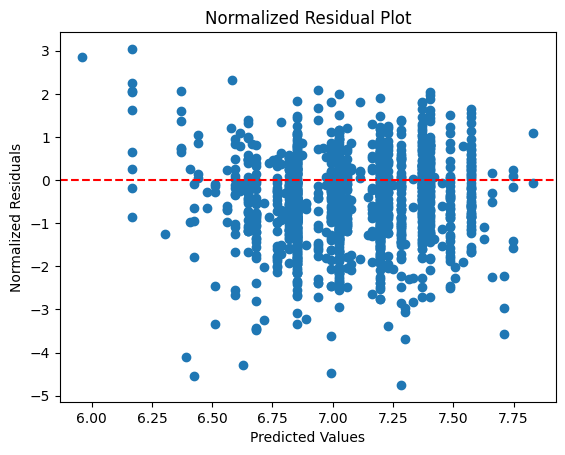

In [98]:

# Calculate the residuals
residuals = y_test - y_pred_test

# Normalize the residuals
normalized_residuals = residuals / np.std(residuals)

# Plot the normalized residuals against the predicted values
plt.scatter(y_pred_test, normalized_residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Normalized Residuals')
plt.title('Normalized Residual Plot')
plt.show()